# Employee Training Course Recommendation System

**Authors:** Dermot O'Brien
***

## Overview

HR places significant emphasis on identifying suitable training and development initiatives tailored to each individual employee.

The provision of training is essential to help employees fill their skill gaps, not only for their present roles but also to prepare them for future advancements. Investing in training and development greatly contributes to boosting self-assurance and overall job contentment among employees, ultimately leading to a decrease in employee turnover. HR departments must consistently analyze employees' skill gaps and implement ongoing training programs accordingly.

## Business Problem

Sometimes it's not easy for an employee or manager to identify their own skill gaps, or which skills they should prioritize learning. In order to combat this, we will create a recommendation system that uses their past course ratings and the ratings of similar employees to offer the right courses to them.

## Data Understanding

The dataset comprises of employee ratings assigned to courses they've completed in past corporate training programs. Each rating entry includes the employee's ID and name, along with the course ID and course name. The ratings are scored on a scale from one to five, with five denoting the highest rating.

Our objective is to develop an algorithm capable of predicting the potential rating an employee might assign to a course they haven't yet undertaken. The underlying assumption is that if the employee finds the course relevant and fitting, they will tend to give a higher rating.

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Input, Embedding, Flatten, Concatenate, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
import logging
from keras.optimizers import Adam

%matplotlib inline

2023-09-20 12:24:27.535623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Import the data set
ratings_df = pd.read_csv("./ratings_data.csv")
ratings_df.head()

,EmployeeID,EmpName,CourseID,CourseName,Rating
0,1408,Ignace Ormonde,14,Video Production,3
1,1249,Gabriela Balcon,17,Translation,2
2,1158,Enrique Lewer,8,IT Architecture,3
3,1564,Wallie Byrd,18,Natural Language Processing,3
4,1334,Hannah Ganter,6,Java Programming,4


In [3]:
# Check the shape
ratings_df.shape

(1000, 5)

In [4]:
# Check for nulls and dtypes
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   EmployeeID  1000 non-null   int64 
 1   EmpName     1000 non-null   object
 2   CourseID    1000 non-null   int64 
 3   CourseName  1000 non-null   object
 4   Rating      1000 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 39.2+ KB


In [5]:
# perform a value counts to see frequencies of courses taken
ratings_df.CourseID.value_counts().head()

18    50
22    47
12    47
3     46
5     46
Name: CourseID, dtype: int64

In [6]:
# perform a value counts to see frequencies of employees taking courses
ratings_df.EmployeeID.value_counts().head()

1620    6
1029    5
1948    5
1690    5
1983    5
Name: EmployeeID, dtype: int64

## Data Preparation

Let's start by creating two data frames, unique lists of employees and courses

In [7]:
# Build list of unique Employees
# last column in each row represents how many courses this person has taken
emp_list = ratings_df.groupby(
            ['EmployeeID', 'EmpName']).size().reset_index()
print("Total Employees: ", len(emp_list))
emp_list.sort_values(by=0, ascending=False).head()

Total Employees:  638


,EmployeeID,EmpName,0
392,1620,Antoinette Holleworth,6
34,1055,Teddie Lutwidge,5
627,1983,Yolane Braun,5
19,1029,Kattie Tenbrug,5
601,1948,Bev Vagg,5


In [8]:
# Build list of unique Courses
# last column in each row represents how many times this course has been rated
course_list = ratings_df.groupby(
                ['CourseID', 'CourseName']).size().reset_index()
print("Total Courses: ", len(course_list))
course_list.sort_values(by=0, ascending=False).head()

Total Courses:  25


,CourseID,CourseName,0
17,18,Natural Language Processing,50
11,12,People Management,47
21,22,Animation,47
2,3,Data Management,46
4,5,HelpDesk,46


/var/folders/lp/nqd19lj97tl7_421bdh_0gc00000gn/T/ipykernel_80150/350039410.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = ratings_df.corr()


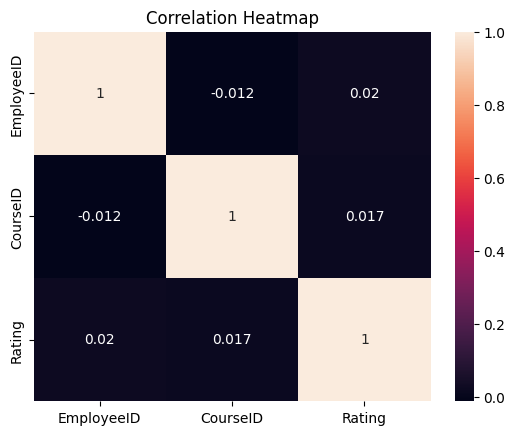

In [9]:
# Assuming df is a DataFrame containing your features and target
correlation_matrix = ratings_df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Heatmap')
plt.show()

### Prepare Embedings

In [10]:
EMP_EMBEDDING_DIM = 5
COURSE_EMBEDDING_DIM = 5
MAX_EMP_ID = 2001  # Make sure this is the number of unique Employee IDs + 1

# Make sure to populate course_list with actual unique course IDs from your dataset
# List of unique course IDs
MAX_COURSE_ID = len(course_list) + 1  # This should be the number of unique Course IDs + 1

def build_embedding(input_shape, input_name, embedding_dim, vocab_size, flatten_name):
    """Builds and returns layers for embedding."""
    inp = Input(shape=input_shape, name=input_name)
    embed = Embedding(vocab_size, embedding_dim, name=f"{input_name}-Embedding")(inp)
    flat = Flatten(name=flatten_name)(embed)
    return inp, flat

# Build employee embedding vector
emp_input, emp_vec = build_embedding([1], 'Emp-Input', EMP_EMBEDDING_DIM, MAX_EMP_ID, 'Emp-Flatten')

# Build course embedding vector
course_input, course_vec = build_embedding([1], 'Course-Input', COURSE_EMBEDDING_DIM, MAX_COURSE_ID, 'Course-Flatten')

# Merge the vectors
merged_vec = Concatenate()([emp_vec, course_vec])

## Building Keras Model

The recommensation system works as follow
* Predict the ratings a given employee may give a course they have not taken
* Predict ratings of all courses for all employees
* Recommend the courses that have the top predicted ratings

First, we split the data into a training and a testing set, using 90% for the training since there isn't too much data. We then create a nueral network with fully connected dense layers with batch normalization, dropout layers and L2 regularization to reduce overfitting.

In [11]:
ratings_train, ratings_test=train_test_split(ratings_df, test_size=0.1)

In [12]:
# Initialize random seed for reproducibility
np.random.seed(1)

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Initialize variables to hold the best model and lowest test loss
best_model = None
lowest_test_loss = float('inf')

# List of regularization factors and dropout rates to try
l2_factors = [0.0001, 0.001, 0.01]
dropout_rates = [0.2, 0.3, 0.4]

# Iterate through all combinations of hyperparameters
for l2_factor in l2_factors:
    for dropout_rate in dropout_rates:
        logger.info(f"Training model with L2 regularization = {l2_factor} and dropout rate = {dropout_rate}")

        # Inputs
        emp_input = Input(shape=(1,), name='Emp-Input')
        course_input = Input(shape=(1,), name='Course-Input')

        # Embedding layers with regularization
        emp_embedding = Embedding(output_dim=5, input_dim=2001, input_length=1, name='Emp-Embedding')(emp_input)
        course_embedding = Embedding(output_dim=5, input_dim=26, input_length=1, name='Course-Embedding')(course_input)

        # Flatten
        emp_flatten = Flatten()(emp_embedding)
        course_flatten = Flatten()(course_embedding)

        # Concatenate
        concat = Concatenate()([emp_flatten, course_flatten])

        # Fully connected layers with BatchNorm, Dropout, and Regularization
        dense1 = Dense(64, activation='relu', kernel_regularizer=l2(l2_factor))(concat)
        batch_norm1 = BatchNormalization()(dense1)
        dropout1 = Dropout(dropout_rate)(batch_norm1)

        dense2 = Dense(32, activation='relu', kernel_regularizer=l2(l2_factor))(dropout1)
        batch_norm2 = BatchNormalization()(dense2)
        dropout2 = Dropout(dropout_rate)(batch_norm2)

        # Output layer
        output = Dense(1)(dropout2)

        # Compile
        model = Model(inputs=[emp_input, course_input], outputs=output)
        model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

        model.summary()

        # Train the model
        model_fit = model.fit(
            x=[ratings_train.EmployeeID, ratings_train.CourseID],
            y=ratings_train.Rating,
            epochs=50,
            batch_size=32,
            verbose=1,
            validation_split=0.2,
            callbacks=[early_stopping, model_checkpoint]
        )

        # Evaluate the model
        test_loss = model.evaluate(
            x=[ratings_test.EmployeeID, ratings_test.CourseID],
            y=ratings_test.Rating
        )

        logger.info(f"Test loss with L2 regularization = {l2_factor} and dropout rate = {dropout_rate}: {test_loss}")

        # Check if this model is better than previous best model
        if test_loss < lowest_test_loss:
            logger.info(f"New best model found with test loss = {test_loss}")
            best_model = model
            lowest_test_loss = test_loss

            # Optionally save the best model to disk
            best_model.save("best_model_so_far.h5")

# Now `best_model` contains the best model found during the hyperparameter search,
# and you can proceed to use it for predictions or further analysis.

INFO:__main__:Training model with L2 regularization = 0.0001 and dropout rate = 0.2


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Emp-Input (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 Course-Input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 Emp-Embedding (Embedding)   (None, 1, 5)                 10005     ['Emp-Input[0][0]']           
                                                                                                  
 Course-Embedding (Embeddin  (None, 1, 5)                 130       ['Course-Input[0][0]']        
 g)                                                                                           

/Users/dermotobrien/opt/anaconda3/envs/main-env/lib/python3.10/site-packages/keras/src/engine/data_adapter.py:1798: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/50
23/23 [==============================] - 2s 13ms/step - loss: 11.5324 - val_loss: 9.2220
Epoch 2/50
23/23 [==============================] - 0s 4ms/step - loss: 9.7566 - val_loss: 9.0619
Epoch 3/50
 1/23 [>.............................] - ETA: 0s - loss: 10.0764

/Users/dermotobrien/opt/anaconda3/envs/main-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 0s 5ms/step - loss: 9.3541 - val_loss: 8.9117
Epoch 4/50
23/23 [==============================] - 0s 5ms/step - loss: 8.5716 - val_loss: 8.7786
Epoch 5/50
23/23 [==============================] - 0s 4ms/step - loss: 8.1075 - val_loss: 8.6702
Epoch 6/50
23/23 [==============================] - 0s 4ms/step - loss: 7.5560 - val_loss: 8.5997
Epoch 7/50
23/23 [==============================] - 0s 4ms/step - loss: 6.8453 - val_loss: 8.5465
Epoch 8/50
23/23 [==============================] - 0s 4ms/step - loss: 6.4131 - val_loss: 8.4360
Epoch 9/50
23/23 [==============================] - 0s 5ms/step - loss: 6.2784 - val_loss: 8.2831
Epoch 10/50
23/23 [==============================] - 0s 4ms/step - loss: 5.7497 - val_loss: 8.0668
Epoch 11/50
23/23 [==============================] - 0s 4ms/step - loss: 5.4514 - val_loss: 8.0182
Epoch 12/50
23/23 [==============================] - 0s 4ms/step - loss: 5.0405 - val_loss: 7.8737
Epoch 13/50
23/23 [=========

INFO:__main__:Test loss with L2 regularization = 0.0001 and dropout rate = 0.2: 2.1806764602661133
INFO:__main__:New best model found with test loss = 2.1806764602661133
INFO:__main__:Training model with L2 regularization = 0.0001 and dropout rate = 0.3


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Emp-Input (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 Course-Input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 Emp-Embedding (Embedding)   (None, 1, 5)                 10005     ['Emp-Input[0][0]']           
                                                                                                  
 Course-Embedding (Embeddin  (None, 1, 5)                 130       ['Course-Input[0][0]']        
 g)                                                                                         

23/23 [==============================] - 0s 3ms/step - loss: 1.8119 - val_loss: 2.0692
Epoch 44/50
23/23 [==============================] - 0s 3ms/step - loss: 1.7828 - val_loss: 2.0908
Epoch 45/50
23/23 [==============================] - 0s 3ms/step - loss: 1.6019 - val_loss: 2.0499
Epoch 46/50
4/4 [==============================] - 0s 2ms/step - loss: 1.7653


INFO:__main__:Test loss with L2 regularization = 0.0001 and dropout rate = 0.3: 1.7653378248214722
INFO:__main__:New best model found with test loss = 1.7653378248214722
INFO:__main__:Training model with L2 regularization = 0.0001 and dropout rate = 0.4


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Emp-Input (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 Course-Input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 Emp-Embedding (Embedding)   (None, 1, 5)                 10005     ['Emp-Input[0][0]']           
                                                                                                  
 Course-Embedding (Embeddin  (None, 1, 5)                 130       ['Course-Input[0][0]']        
 g)                                                                                         

INFO:__main__:Test loss with L2 regularization = 0.0001 and dropout rate = 0.4: 1.9915862083435059
INFO:__main__:Training model with L2 regularization = 0.001 and dropout rate = 0.2


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Emp-Input (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 Course-Input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 Emp-Embedding (Embedding)   (None, 1, 5)                 10005     ['Emp-Input[0][0]']           
                                                                                                  
 Course-Embedding (Embeddin  (None, 1, 5)                 130       ['Course-Input[0][0]']        
 g)                                                                                         

INFO:__main__:Test loss with L2 regularization = 0.001 and dropout rate = 0.2: 2.1749467849731445
INFO:__main__:Training model with L2 regularization = 0.001 and dropout rate = 0.3


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Emp-Input (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 Course-Input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 Emp-Embedding (Embedding)   (None, 1, 5)                 10005     ['Emp-Input[0][0]']           
                                                                                                  
 Course-Embedding (Embeddin  (None, 1, 5)                 130       ['Course-Input[0][0]']        
 g)                                                                                         

INFO:__main__:Test loss with L2 regularization = 0.001 and dropout rate = 0.3: 2.0058047771453857
INFO:__main__:Training model with L2 regularization = 0.001 and dropout rate = 0.4


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Emp-Input (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 Course-Input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 Emp-Embedding (Embedding)   (None, 1, 5)                 10005     ['Emp-Input[0][0]']           
                                                                                                  
 Course-Embedding (Embeddin  (None, 1, 5)                 130       ['Course-Input[0][0]']        
 g)                                                                                         

INFO:__main__:Test loss with L2 regularization = 0.001 and dropout rate = 0.4: 2.043519973754883
INFO:__main__:Training model with L2 regularization = 0.01 and dropout rate = 0.2


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Emp-Input (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 Course-Input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 Emp-Embedding (Embedding)   (None, 1, 5)                 10005     ['Emp-Input[0][0]']           
                                                                                                  
 Course-Embedding (Embeddin  (None, 1, 5)                 130       ['Course-Input[0][0]']        
 g)                                                                                         

INFO:__main__:Test loss with L2 regularization = 0.01 and dropout rate = 0.2: 2.543424129486084
INFO:__main__:Training model with L2 regularization = 0.01 and dropout rate = 0.3


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Emp-Input (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 Course-Input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 Emp-Embedding (Embedding)   (None, 1, 5)                 10005     ['Emp-Input[0][0]']           
                                                                                                  
 Course-Embedding (Embeddin  (None, 1, 5)                 130       ['Course-Input[0][0]']        
 g)                                                                                         

INFO:__main__:Test loss with L2 regularization = 0.01 and dropout rate = 0.3: 2.4824025630950928
INFO:__main__:Training model with L2 regularization = 0.01 and dropout rate = 0.4


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Emp-Input (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 Course-Input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 Emp-Embedding (Embedding)   (None, 1, 5)                 10005     ['Emp-Input[0][0]']           
                                                                                                  
 Course-Embedding (Embeddin  (None, 1, 5)                 130       ['Course-Input[0][0]']        
 g)                                                                                         

INFO:__main__:Test loss with L2 regularization = 0.01 and dropout rate = 0.4: 2.731604814529419


In [13]:
print(best_model)
print(lowest_test_loss)

1.7653378248214722


## Rating Predictions

In [14]:
# predicting the Rating for a given employee and a course
# for employee 1029 and course 8

best_model.predict(
    [pd.Series([1029]),
     pd.Series([8])])

1/1 [==============================] - 0s 138ms/step


array([[2.44517]], dtype=float32)

## Course Recommendations

For an example, let's recommend a list of courses for an employee, Harriot Laflin

In [28]:
def get_top_5_for_individual(best_model, emp_list, ratings_df, course_list):
    # Get the employee name through a popup prompt
    emp_to_predict = input("Please enter the name of the employee: ")
    
    # Call the modified recommend_courses function to get top 5 courses and their ratings
    top_courses, top_ratings = recommend_courses(emp_to_predict, best_model, emp_list, ratings_df, course_list)
    
    # Round the ratings to 1 decimal place
    top_ratings = [round(rating, 1) for rating in top_ratings]
    
    # Create a DataFrame to display the results in a visually appealing manner
    top_5_df = pd.DataFrame({
        'Predicted Rating': top_ratings,
        'CourseID': top_courses,
        'Course Name': [course_list[course_list["CourseID"] == course_id]["CourseName"].iloc[0] for course_id in top_courses]
    })
    
    # Formatters for each column
    formatters = {
        'Predicted Rating': '{:,.1f}'.format,
        'Course Name': '{:<}'.format
    }

    print(f"Top 5 recommended courses for {emp_to_predict} are:")
    print(top_5_df.to_string(index=False, formatters=formatters))  # Remove the index by setting index=False and use formatters for formatting

    return top_5_df

def recommend_courses(emp_to_predict, best_model, emp_list, ratings_df, course_list):
    try:
        pred_emp_id = emp_list[emp_list['EmpName'] == emp_to_predict]["EmployeeID"].iloc[0]
    except IndexError:
        return f"Employee name {emp_to_predict} not found."

    completed_courses = ratings_df[ratings_df["EmployeeID"] == pred_emp_id]["CourseID"].unique()
    new_courses = course_list[~course_list["CourseID"].isin(completed_courses)]["CourseID"]

    emp_dummy_list = pd.Series(np.array([pred_emp_id for i in range(len(new_courses))]))
    projected_ratings = best_model.predict([emp_dummy_list, new_courses], verbose=0)
    flat_ratings = np.array([x[0] for x in projected_ratings])

    # Sort by ratings and take top 5
    top_5_idx = (-flat_ratings).argsort()[:5]
    top_5_courses = new_courses.iloc[top_5_idx].tolist()
    top_5_ratings = flat_ratings[top_5_idx].tolist()

    return top_5_courses, top_5_ratings

# Example usage
top_5_df = get_top_5_for_individual(best_model, emp_list, ratings_df, course_list)

Please enter the name of the employee: Yolane Braun
Top 5 recommended courses for Yolane Braun are:
Predicted Rating  CourseID        Course Name
             4.1        22          Animation
             3.9        12  People Management
             3.5         2    Cloud Computing
             3.5        10 Mobile Development
             3.2        25  Digital Marketing


## Visualizations

#### Plotting Training and Validation Losses

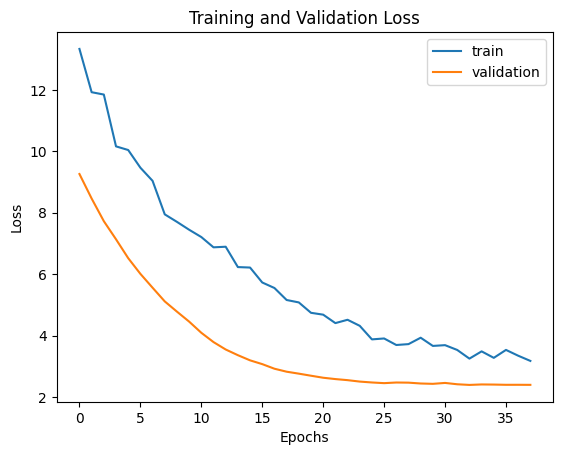

In [19]:
import matplotlib.pyplot as plt

# Assuming model_fit is the History object returned by the model.fit() method
# Plotting training and validation loss
plt.plot(model_fit.history['loss'], label='train')
plt.plot(model_fit.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#### Distribution of Predicted Ratings

4/4 [==============================] - 0s 1ms/step


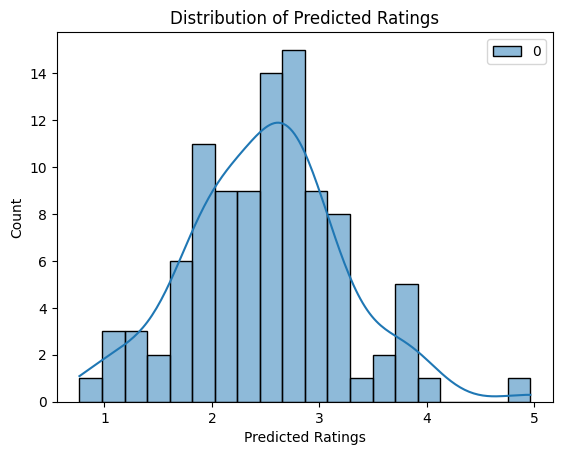

In [20]:
import seaborn as sns

# Assuming pred_ratings is the list/array of your model's predictions
pred_ratings = best_model.predict([ratings_test.EmployeeID, ratings_test.CourseID])
sns.histplot(pred_ratings, bins=20, kde=True)
plt.xlabel('Predicted Ratings')
plt.title('Distribution of Predicted Ratings')
plt.show()

#### Top Predicted Courses for All Employees

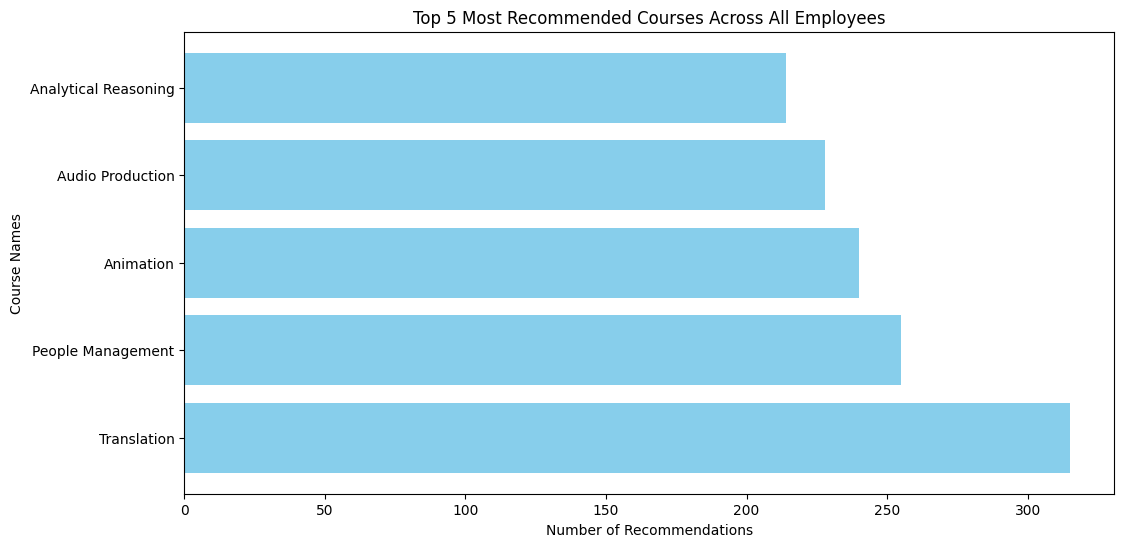

In [21]:
from collections import Counter
import matplotlib.pyplot as plt

course_tally = Counter()

# Assume emp_list, ratings_df, and course_list are defined, and best_model is your trained model.
for emp_name in emp_list['EmpName']:
    top_courses, _ = recommend_courses(emp_name, best_model, emp_list, ratings_df, course_list)  # Assuming recommend_courses() returns top_courses and top_ratings
    course_tally.update(top_courses)

# Get the 5 most common courses
most_common_courses = course_tally.most_common(5)

# Extract the course names and counts
course_ids = [item[0] for item in most_common_courses]
course_counts = [item[1] for item in most_common_courses]
course_names = [course_list[course_list['CourseID'] == course_id]['CourseName'].iloc[0] for course_id in course_ids]

# Create the histogram
plt.figure(figsize=(12, 6))
plt.barh(course_names, course_counts, color='skyblue')
plt.xlabel('Number of Recommendations')
plt.ylabel('Course Names')
plt.title('Top 5 Most Recommended Courses Across All Employees')
plt.show()

## Conclusions
Using collaborative filtering, I've created a funcional nueral network using dense layers, batch norm, dropout layers, and L2 regularization to increase the accuracy of the course recommendation system, with a test loss of 1.76. I grid searched on L2 factors and dropout rates to find the most optimal combination of hyperparameters, and created simple visuals to better understand how the model is working.

When examining all the recommended courses for each employee, we notice that the top courses are Translation, People Managmenet, and Animation courses. For a company like IMDB, this makes a ton of sense. 